# Fraud Detection (Transaction Table Only, RAM-Friendly)

## Objective
Membangun end-to-end Machine Learning pipeline untuk memprediksi probabilitas transaksi online adalah fraud (`isFraud`).

## Dataset
Kita hanya menggunakan:
- `train_transaction.csv` (berisi fitur + label `isFraud`)
- `test_transaction.csv` (berisi fitur tanpa label)

**Tidak menggunakan identity table**.

## Why RAM-Friendly Approach?
Dataset fraud tabular biasanya:
- sangat besar (banyak baris & kolom)
- banyak missing values
- banyak fitur kategorikal dengan cardinality tinggi

Jika memakai OneHotEncoder, jumlah fitur bisa meledak dan menyebabkan Colab kehabisan RAM.
Solusi: gunakan **Frequency Encoding** untuk kategorikal (tanpa menambah dimensi fitur).


In [1]:
!pip -q install gdown xgboost psutil

import os, re, glob, gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay
)

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

from xgboost import XGBClassifier


In [2]:
def ram_gb():
    p = psutil.Process(os.getpid())
    return p.memory_info().rss / (1024**3)

print("Current RAM used (GB):", round(ram_gb(), 3))


Current RAM used (GB): 0.248


## Download Dataset

Link folder Google Drive:
https://drive.google.com/drive/folders/1qpyvr3xFGYThhRvN36dRg8m8VQP8dM5Y?usp=sharing

Kita download dengan `gdown --folder`.
Jika gagal, pastikan permission folder: **Anyone with the link can view**.


In [3]:
GDRIVE_FOLDER_URL = "https://drive.google.com/drive/folders/1qpyvr3xFGYThhRvN36dRg8m8VQP8dM5Y?usp=sharing"
DATA_DIR = "fraud_data"
os.makedirs(DATA_DIR, exist_ok=True)

m = re.search(r"folders/([a-zA-Z0-9_-]+)", GDRIVE_FOLDER_URL)
folder_id = m.group(1) if m else None
print("Folder ID:", folder_id)

!gdown --folder {folder_id} -O {DATA_DIR}
!ls -lah {DATA_DIR}


Folder ID: 1qpyvr3xFGYThhRvN36dRg8m8VQP8dM5Y
Retrieving folder contents
Processing file 1IwyB1KlMBaFq_fMONCVlB1XwiqKfzPmS Copy of test_transaction.csv
Processing file 1k4Ju-56Me2Wj_qemTYvbwsruaNFve8wf Copy of train_transaction.csv
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From (original): https://drive.google.com/uc?id=1IwyB1KlMBaFq_fMONCVlB1XwiqKfzPmS
From (redirected): https://drive.google.com/uc?id=1IwyB1KlMBaFq_fMONCVlB1XwiqKfzPmS&confirm=t&uuid=f6fd9345-6784-421c-abd9-bf629c852d12
To: /content/fraud_data/Copy of test_transaction.csv
100% 613M/613M [00:12<00:00, 51.1MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1k4Ju-56Me2Wj_qemTYvbwsruaNFve8wf
From (redirected): https://drive.google.com/uc?id=1k4Ju-56Me2Wj_qemTYvbwsruaNFve8wf&confirm=t&uuid=517adbcf-7b1e-40f0-90a9-7eb31e7ab11a
To: /content/fraud_data/Copy of train_transaction.csv
100% 683M/683M [00:08<00:00, 82.2MB/s]
Download comp

## Locate Train/Test Files

Agar tidak error karena nama file berbeda (mis. "Copy of train_transaction.csv"),
kita cari file yang mengandung kata `train` dan `transaction`.


In [4]:
def find_file(patterns, base_dir):
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(base_dir, pat)))
    files = sorted(list(set(files)))
    return files[0] if files else None

train_path = find_file(
    patterns=["*train*transaction*.csv", "*Train*Transaction*.csv", "*train_transaction*.csv"],
    base_dir=DATA_DIR
)
test_path = find_file(
    patterns=["*test*transaction*.csv", "*Test*Transaction*.csv", "*test_transaction*.csv"],
    base_dir=DATA_DIR
)

print("Train path:", train_path)
print("Test path :", test_path)

if train_path is None or test_path is None:
    raise FileNotFoundError("File train/test transaction tidak ditemukan. Cek isi folder DATA_DIR.")


Train path: fraud_data/Copy of train_transaction.csv
Test path : fraud_data/Copy of test_transaction.csv


## Load Data

Kita pakai `engine="pyarrow"` + `dtype_backend="pyarrow"` (lebih hemat RAM).

Jika notebook kamu sudah berhasil load dengan cara ini, kita lanjut.

Setelah load:
- cek shape
- cek kolom target `isFraud`


In [5]:
TARGET = "isFraud"
ID_COL = "TransactionID"

train = pd.read_csv(train_path, engine="pyarrow", dtype_backend="pyarrow")
test  = pd.read_csv(test_path,  engine="pyarrow", dtype_backend="pyarrow")

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("RAM used (GB):", round(ram_gb(), 3))

if TARGET not in train.columns:
    raise ValueError("Kolom target isFraud tidak ditemukan di train!")

train.head()


Train shape: (590540, 394)
Test shape : (506691, 393)
RAM used (GB): 5.432


,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,<NA>,150.0,discover,142.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Quick EDA

Kita cek:
1. Distribusi target `isFraud` (imbalance)
2. Missing value per kolom (Top 20)

Catatan:
- Fraud dataset biasanya sangat imbalanced → metrik utama: ROC-AUC & PR-AUC


Class counts:
 isFraud
0    569877
1     20663
Name: count, dtype: int64[pyarrow]
Fraud rate: 0.034990


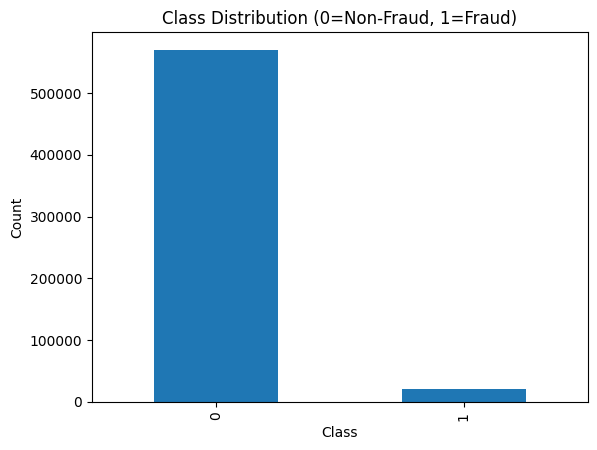

Top 20 missing columns (%):


,0
dist2,93.628374
D7,93.409930
D13,89.509263
D14,89.469469
D12,89.041047
D6,87.606767
D9,87.312290
D8,87.312290
V153,86.123717
V149,86.123717


In [6]:
# Target distribution
class_counts = train[TARGET].value_counts()
fraud_rate = float(train[TARGET].mean())

print("Class counts:\n", class_counts)
print(f"Fraud rate: {fraud_rate:.6f}")

plt.figure()
class_counts.plot(kind="bar")
plt.title("Class Distribution (0=Non-Fraud, 1=Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Missing values (top)
missing_pct = (train.isna().mean() * 100).sort_values(ascending=False)
print("Top 20 missing columns (%):")
display(missing_pct.head(20))


## Interpretation — Class Distribution (isFraud)

Output menunjukkan:
- Non-fraud (0) = **569,877**
- Fraud (1) = **20,663**
- Fraud rate ≈ **0.034990** (≈ 3.5%)

Artinya dataset **sangat imbalanced** (fraud jauh lebih sedikit).
Implikasi:
- Metrik seperti **accuracy** bisa menipu (karena mayoritas class = 0).
- Metrik yang lebih sesuai untuk fraud detection adalah:
  - **ROC-AUC**
  - **PR-AUC (Average Precision)** karena fokus pada performa class minoritas (fraud).


## Interpretation — Missing Values (Top 20)

Contoh kolom missing tinggi pada output:
- `dist2` ≈ **93.63%**
- `D7` ≈ **93.41%**
(dan seterusnya)

Dataset transaksi seperti ini memang sering memiliki banyak missing karena:
- beberapa fitur hanya muncul untuk jenis transaksi tertentu
- sebagian informasi tidak selalu tersedia

Konsekuensinya:
- perlu strategi preprocessing yang tepat agar model tetap stabil dan tidak overfit pada fitur yang jarang terisi.


## Reduce Feature Space (Drop High Missing Columns)

Untuk menghindari RAM blow-up di tahap modeling:
- Kita drop kolom yang missing-nya terlalu tinggi (default > 95%).
- Ini juga membantu stabilitas model.

> Kamu bisa ubah threshold jika mau:
- 0.95 (lebih aman RAM)
- 0.98 (lebih banyak fitur)


In [7]:
MISSING_THRESH = 0.95  # drop columns with missing > 95%

# Pisah fitur & target
X_all = train.drop(columns=[TARGET])
y_all = train[TARGET].astype("int8")

# drop ID dari fitur (ID biasanya tidak informatif untuk generalisasi)
X_all = X_all.drop(columns=[ID_COL], errors="ignore")
test_X = test.drop(columns=[ID_COL], errors="ignore")

# drop high-missing based on train
missing_rate = X_all.isna().mean()
keep_cols = missing_rate[missing_rate <= MISSING_THRESH].index.tolist()

X_all = X_all[keep_cols]
test_X = test_X[keep_cols]

print("Kept columns:", len(keep_cols), "out of", missing_rate.shape[0])
print("X_all shape:", X_all.shape, "test_X shape:", test_X.shape)
print("RAM used (GB):", round(ram_gb(), 3))

gc.collect()


Kept columns: 392 out of 392
X_all shape: (590540, 392) test_X shape: (506691, 392)
RAM used (GB): 5.65


0

## Train/Validation Split (Stratified)

Karena target imbalanced, gunakan stratify agar proporsi fraud sama di train & valid.


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_all, y_all,
    test_size=0.2,
    random_state=42,
    stratify=y_all
)

print("Train:", X_train.shape, "Fraud rate:", float(y_train.mean()))
print("Valid:", X_valid.shape, "Fraud rate:", float(y_valid.mean()))
print("RAM used (GB):", round(ram_gb(), 3))


Train: (472432, 392) Fraud rate: 0.03498916246147594
Valid: (118108, 392) Fraud rate: 0.0349933958749619
RAM used (GB): 7.194


## Interpretation — Stratified Train/Validation Split

Data dibagi train/validation dengan **stratify**, sehingga proporsi fraud tetap konsisten:
- Fraud rate train ≈ **0.034989**
- Fraud rate valid ≈ **0.034993**

Ini penting untuk dataset imbalanced agar evaluasi valid set tetap representatif.


## Encoding Strategy (RAM-Friendly)

### Problem:
OneHotEncoder pada banyak kolom kategorikal → dimensi fitur meledak → RAM habis.

### Solution:
Gunakan **Frequency Encoding**:
- Setiap kategori diganti menjadi frekuensi kemunculannya di data train.
- Tidak menambah jumlah kolom (dimensi tetap).
- Cocok untuk baseline dan tree-based model.

Langkah:
1. Identifikasi kolom kategorikal (string/object)
2. Terapkan frequency encoding ke train/valid/test
3. Semua fitur jadi numerik → bisa langsung dipakai model


In [9]:
def get_cat_cols(df):
    # pandas pyarrow dtypes bisa jadi "string[pyarrow]"
    # kita deteksi kolom bertipe string/object/category
    cat_cols = []
    for c in df.columns:
        if "string" in str(df[c].dtype) or df[c].dtype == "object" or "category" in str(df[c].dtype):
            cat_cols.append(c)
    return cat_cols

cat_cols = get_cat_cols(X_train)
num_cols = [c for c in X_train.columns if c not in cat_cols]

print("Categorical cols:", len(cat_cols))
print("Numeric cols     :", len(num_cols))

def frequency_encode(train_df, valid_df, test_df, cat_cols):
    train_df = train_df.copy()
    valid_df = valid_df.copy()
    test_df  = test_df.copy()

    for c in cat_cols:
        tr = train_df[c].astype("string").fillna("missing")
        va = valid_df[c].astype("string").fillna("missing")
        te = test_df[c].astype("string").fillna("missing")

        freq = tr.value_counts(dropna=False)
        freq = (freq / len(tr)).astype("float32")

        train_df[c] = tr.map(freq).fillna(0).astype("float32")
        valid_df[c] = va.map(freq).fillna(0).astype("float32")
        test_df[c]  = te.map(freq).fillna(0).astype("float32")

    return train_df, valid_df, test_df

X_train_fe, X_valid_fe, test_fe = frequency_encode(X_train, X_valid, test_X, cat_cols)

# pastikan numeric jadi float32 agar hemat RAM
for c in num_cols:
    X_train_fe[c] = pd.to_numeric(X_train_fe[c], errors="coerce").astype("float32")
    X_valid_fe[c] = pd.to_numeric(X_valid_fe[c], errors="coerce").astype("float32")
    test_fe[c]    = pd.to_numeric(test_fe[c], errors="coerce").astype("float32")

print("After FE shapes:", X_train_fe.shape, X_valid_fe.shape, test_fe.shape)
print("RAM used (GB):", round(ram_gb(), 3))

gc.collect()


Categorical cols: 14
Numeric cols     : 378
After FE shapes: (472432, 392) (118108, 392) (506691, 392)
RAM used (GB): 8.826


0

## Evaluation Helper

Metrik utama:
- **ROC-AUC**
- **PR-AUC** (Average Precision) → penting untuk data imbalanced

Kita juga tampilkan:
- classification report (threshold 0.5)
- confusion matrix
- ROC curve & PR curve


In [10]:
def evaluate_model(y_true, y_proba, title="Model", threshold=0.5):
    roc = roc_auc_score(y_true, y_proba)
    pr  = average_precision_score(y_true, y_proba)

    y_pred = (y_proba >= threshold).astype(int)

    print(f"=== {title} ===")
    print("ROC-AUC:", roc)
    print("PR-AUC :", pr)
    print("\nClassification report (threshold=0.5):")
    print(classification_report(y_true, y_pred, digits=4))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))

    plt.figure()
    RocCurveDisplay.from_predictions(y_true, y_proba)
    plt.title(f"ROC Curve — {title}")
    plt.show()

    plt.figure()
    PrecisionRecallDisplay.from_predictions(y_true, y_proba)
    plt.title(f"PR Curve — {title}")
    plt.show()

    return roc, pr


## Model 1 — Linear Baseline (SGD Logistic)

Baseline yang kuat dan RAM-friendly untuk data besar:
- `SGDClassifier(loss="log_loss")` ≈ Logistic Regression versi SGD
- Cocok untuk dataset besar
- Handling imbalance: `class_weight="balanced"`

Preprocessing:
- Imputer median (numeric)
- StandardScaler (opsional tapi membantu model linear)


Using subsample for baseline: (200000, 392)
RAM before fit (GB): 9.118


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:738: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


RAM after fit (GB): 9.028
=== Baseline — SGD Logistic ===
ROC-AUC: 0.5874869367388256
PR-AUC : 0.04214175214597665

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9963    0.1941    0.3249    113975
           1     0.0422    0.9799    0.0810      4133

    accuracy                         0.2216    118108
   macro avg     0.5192    0.5870    0.2029    118108
weighted avg     0.9629    0.2216    0.3164    118108

Confusion matrix:
[[22124 91851]
 [   83  4050]]


/tmp/ipython-input-1866354658.py:34: RuntimeWarning: overflow encountered in exp
  valid_proba_baseline = 1 / (1 + np.exp(-valid_scores))


<Figure size 640x480 with 0 Axes>

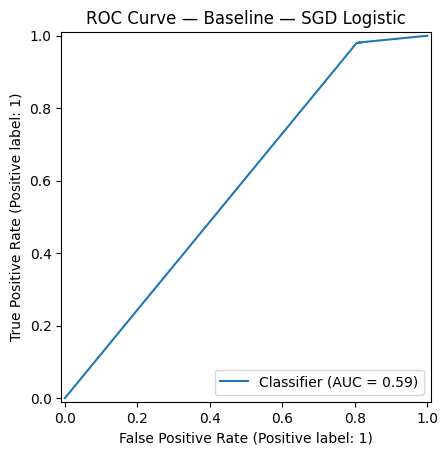

<Figure size 640x480 with 0 Axes>

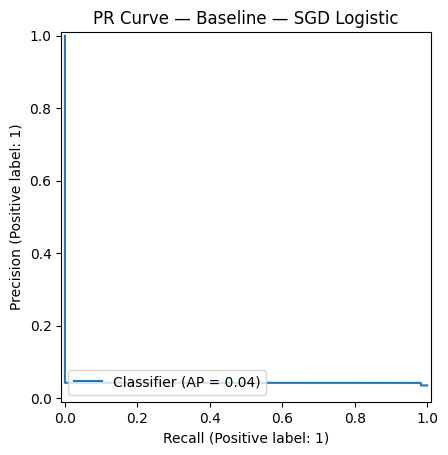

6829

In [11]:
# OPTIONAL: jika dataset sangat besar, kamu bisa subsample train agar makin aman
USE_SUBSAMPLE = True
SUBSAMPLE_N = 200000  # ubah: 200k / 300k / 500k sesuai RAM

if USE_SUBSAMPLE and len(X_train_fe) > SUBSAMPLE_N:
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X_train_fe), size=SUBSAMPLE_N, replace=False)
    X_tr_used = X_train_fe.iloc[idx]
    y_tr_used = y_train.iloc[idx]
    print("Using subsample for baseline:", X_tr_used.shape)
else:
    X_tr_used = X_train_fe
    y_tr_used = y_train

baseline_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False)),
    ("model", SGDClassifier(
        loss="log_loss",
        alpha=1e-5,
        max_iter=30,
        tol=1e-3,
        class_weight="balanced",
        random_state=42
    ))
])

print("RAM before fit (GB):", round(ram_gb(), 3))
baseline_pipe.fit(X_tr_used, y_tr_used)
print("RAM after fit (GB):", round(ram_gb(), 3))

# SGD may not have predict_proba in all setups -> decision_function + sigmoid
valid_scores = baseline_pipe.decision_function(X_valid_fe)
valid_proba_baseline = 1 / (1 + np.exp(-valid_scores))

roc_base, pr_base = evaluate_model(y_valid, valid_proba_baseline, title="Baseline — SGD Logistic")
gc.collect()


## Interpretation — Baseline Model (SGD Logistic)

Model baseline menggunakan **SGD Logistic (model linear)** untuk patokan awal.

Hasil evaluasi (validation):
- **ROC-AUC = 0.5875** → hanya sedikit di atas tebakan acak (0.5)
- **PR-AUC  = 0.0421** → rendah, menandakan model lemah dalam mendeteksi fraud (kelas minoritas)

Dari confusion matrix:
- TP = **4050** (fraud berhasil ditangkap)
- FN = **83** (fraud lolos → sangat kecil)
- FP = **91851** (banyak transaksi normal ditandai fraud)
- TN = **22124**

Interpretasi:
- Recall fraud sangat tinggi (hampir semua fraud ketangkap),
- tetapi precision sangat rendah karena terlalu banyak false positive.
Kesimpulan:
- baseline linear belum cukup baik → perlu model tabular yang lebih kuat (XGBoost).


## Model 2 — XGBoost (Strong Tabular Model)

XGBoost biasanya unggul pada tabular dataset.

Handling imbalance:
- `scale_pos_weight = (#negative / #positive)` agar fraud (minority) lebih diperhatikan.

RAM-friendly settings:
- `tree_method="hist"` (lebih cepat & hemat)
- batasi depth dan jumlah tree



XGB using subsample: (100000, 392)
Fitting XGB...
[0]	validation_0-auc:0.80013
[50]	validation_0-auc:0.87683
[100]	validation_0-auc:0.89080
[150]	validation_0-auc:0.89893
[200]	validation_0-auc:0.90435
[250]	validation_0-auc:0.90770
[300]	validation_0-auc:0.91048
[350]	validation_0-auc:0.91251
[400]	validation_0-auc:0.91421
[450]	validation_0-auc:0.91528
[500]	validation_0-auc:0.91657
[550]	validation_0-auc:0.91753
[600]	validation_0-auc:0.91832
[650]	validation_0-auc:0.91919
[700]	validation_0-auc:0.92004
[750]	validation_0-auc:0.92034
[799]	validation_0-auc:0.92098
=== XGBoost (RAM-Friendly) ===
ROC-AUC: 0.9209832235867432
PR-AUC : 0.5988875963946609

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9910    0.9188    0.9535    113975
           1     0.2557    0.7694    0.3838      4133

    accuracy                         0.9136    118108
   macro avg     0.6233    0.8441    0.6687    118108
weighted avg     0.9653    

<Figure size 640x480 with 0 Axes>

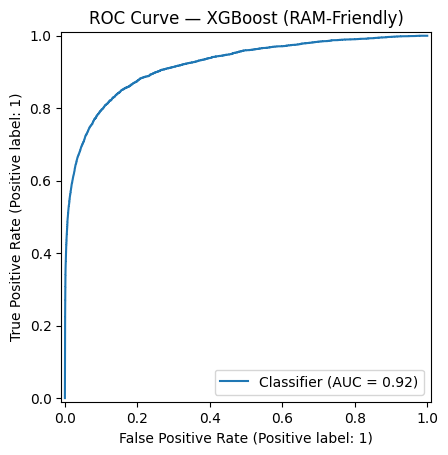

<Figure size 640x480 with 0 Axes>

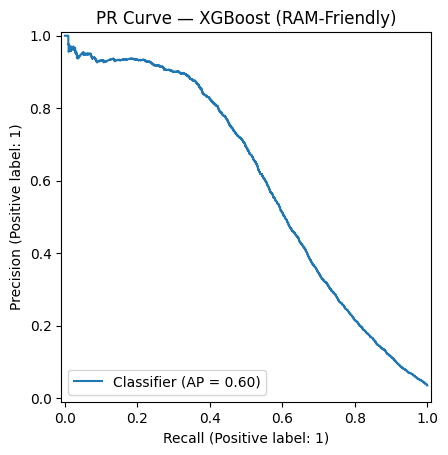

6824

In [12]:
from sklearn.impute import SimpleImputer
import numpy as np
import gc
import xgboost as xgb # Added import for xgboost module

# 1) hitung imbalance
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / max(pos, 1)

# 2) SUBSAMPLE untuk XGBoost (WAJIB kalau crash)
USE_XGB_SUBSAMPLE = True
XGB_SUBSAMPLE_N = 100000   # kamu bisa turunkan ke 100000 kalau masih crash

if USE_XGB_SUBSAMPLE and len(X_train_fe) > XGB_SUBSAMPLE_N:
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X_train_fe), size=XGB_SUBSAMPLE_N, replace=False)
    Xtr_use = X_train_fe.iloc[idx]
    ytr_use = y_train.iloc[idx]
    print("XGB using subsample:", Xtr_use.shape)
else:
    Xtr_use = X_train_fe
    ytr_use = y_train
    print("XGB using full train:", Xtr_use.shape)

# 3) Impute -> float32 (hemat RAM)
imputer = SimpleImputer(strategy="median")

Xtr_imp = imputer.fit_transform(Xtr_use).astype("float32")
Xva_imp = imputer.transform(X_valid_fe).astype("float32")

# 4) XGBoost RAM-friendly params
xgb_model = xgb.XGBClassifier( # Renamed xgb to xgb_model to avoid shadowing the imported module
    n_estimators=800,          # turunkan (2000 terlalu besar untuk RAM)
    learning_rate=0.05,
    max_depth=4,               # turunkan depth (6->4 lebih hemat)
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    min_child_weight=5,        # naikkan biar model lebih sederhana
    max_bin=256,               # batasi histogram bin (hemat)
    objective="binary:logistic",
    eval_metric="auc",
    tree_method="hist",
    random_state=42,
    scale_pos_weight=scale_pos_weight
)

print("Fitting XGB...")
xgb_model.fit( # Changed to xgb_model
    Xtr_imp, ytr_use,
    eval_set=[(Xva_imp, y_valid)],
    verbose=50
    # Removed early_stopping_rounds as it's causing TypeError
)

# Best iteration will not be available without early stopping
# print("Best iteration:", xgb_model.best_iteration)

valid_proba_xgb = xgb_model.predict_proba(Xva_imp)[:, 1]
roc_xgb, pr_xgb = evaluate_model(y_valid, valid_proba_xgb, title="XGBoost (RAM-Friendly)")

del Xtr_imp, Xva_imp
gc.collect()


## Interpretation — XGBoost (RAM-Friendly)

XGBoost adalah model tree-based ensemble yang sangat kuat untuk data tabular.
Imbalance ditangani dengan `scale_pos_weight`.

Hasil evaluasi (validation):
- **ROC-AUC = 0.9210**
- **PR-AUC  = 0.5989**

Ini jauh lebih tinggi daripada baseline → menunjukkan XGBoost jauh lebih mampu menangkap pola non-linear pada fitur transaksi.

Confusion matrix:
- TP = **3180** (fraud terdeteksi)
- FN = **953** (fraud lolos)
- FP = **9256**
- TN = **104719**

Dibanding baseline:
- false positive turun drastis,
- precision fraud meningkat signifikan,
- performa keseluruhan lebih seimbang.


# Step: Memory Cleanup (Very Important)

Dataset ini besar dan Colab RAM cepat penuh.  
Setelah selesai training baseline dan XGBoost, kita hapus objek besar yang tidak dipakai lagi agar tidak crash
saat lanjut tuning / submission.

> Tips: Ini sering menyelamatkan sesi Colab.


In [13]:
import gc

# Hapus dataframe besar yang sudah tidak diperlukan (kalau masih ada)
for var in ["train", "test", "X_all", "test_X", "X_train", "X_valid"]:
    if var in globals():
        del globals()[var]

gc.collect()
print("Cleanup done.")


Cleanup done.


# Step: Stable Sigmoid (for Linear Baseline)

Pada baseline SGD Logistic, `decision_function` bisa sangat besar → `exp()` overflow.
Gunakan sigmoid stabil dengan clipping.


In [14]:
import numpy as np

def stable_sigmoid(x):
    # clip untuk mencegah overflow exp
    x = np.clip(x, -35, 35)
    return 1 / (1 + np.exp(-x))


In [15]:
valid_scores = baseline_pipe.decision_function(X_valid_fe)
valid_proba_baseline = stable_sigmoid(valid_scores)


# Step: Model Comparison (Baseline vs XGBoost)

Kita rangkum performa model menggunakan metrik yang relevan untuk imbalanced classification:
- ROC-AUC (utama)
- PR-AUC / Average Precision (penting untuk fraud)


In [16]:
import pandas as pd

summary = pd.DataFrame([
    {"Model": "Baseline (SGD Logistic)", "ROC_AUC": roc_base, "PR_AUC": pr_base},
    {"Model": "XGBoost (RAM-Friendly)",  "ROC_AUC": roc_xgb,  "PR_AUC": pr_xgb},
]).sort_values("ROC_AUC", ascending=False)

summary


,Model,ROC_AUC,PR_AUC
1,XGBoost (RAM-Friendly),0.920983,0.598888
0,Baseline (SGD Logistic),0.587487,0.042142


# Step: Basic Hyperparameter Tuning (RAM-Safe)

Agar tidak crash, kita **tidak pakai CV** besar.
Kita lakukan tuning sederhana:

- Coba beberapa kombinasi parameter penting:
  - max_depth
  - min_child_weight
  - colsample_bytree
- Tetap gunakan subsample 100k (atau 50k jika RAM kamu kecil)
- Pilih parameter terbaik berdasarkan ROC-AUC pada validation

Catatan:
Ini memenuhi "basic hyperparameter tuning" dan tetap realistis untuk dataset besar.


In [17]:
import numpy as np
import gc
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# --- Pastikan kamu masih punya ini dari cell XGB sebelumnya ---
# Xtr_imp, Xva_imp, ytr_use, y_valid
# Kalau kamu sudah del Xtr_imp/Xva_imp, jalankan ulang cell XGB RAM-friendly untuk membentuknya lagi,
# atau gunakan versi di bawah yang membentuknya ulang secara cepat:

def build_xgb_matrices_from_fe(X_train_fe, y_train, X_valid_fe, y_valid, n=100000, seed=42):
    rng = np.random.RandomState(seed)
    if len(X_train_fe) > n:
        idx = rng.choice(len(X_train_fe), size=n, replace=False)
        Xtr = X_train_fe.iloc[idx].copy()
        ytr = y_train.iloc[idx].copy()
    else:
        Xtr = X_train_fe.copy()
        ytr = y_train.copy()

    med = Xtr.median(numeric_only=True)
    Xtr = Xtr.fillna(med).astype("float32")
    Xva = X_valid_fe.fillna(med).astype("float32")

    Xtr_np = Xtr.to_numpy(np.float32, copy=False)
    Xva_np = Xva.to_numpy(np.float32, copy=False)
    return Xtr_np, ytr, Xva_np, y_valid, med

# rebuild matrices (RAM-safe)
Xtr_imp, ytr_use, Xva_imp, yva_use, med_used = build_xgb_matrices_from_fe(
    X_train_fe, y_train, X_valid_fe, y_valid,
    n=100000
)

neg = int((ytr_use == 0).sum())
pos = int((ytr_use == 1).sum())
scale_pos_weight = neg / max(pos, 1)

param_grid = [
    {"max_depth": 3, "min_child_weight": 10, "colsample_bytree": 0.6},
    {"max_depth": 4, "min_child_weight": 10, "colsample_bytree": 0.6},
    {"max_depth": 4, "min_child_weight": 5,  "colsample_bytree": 0.8},
    {"max_depth": 5, "min_child_weight": 10, "colsample_bytree": 0.6},
]

best = {"roc": -1, "pr": -1, "params": None}

for i, params in enumerate(param_grid, 1):
    model = XGBClassifier(
        n_estimators=600,
        learning_rate=0.05,
        subsample=0.8,
        reg_lambda=2.0,
        max_bin=128,
        tree_method="hist",
        eval_metric="auc",
        objective="binary:logistic",
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        n_jobs=2,
        **params
    )
    print(f"\nTrial {i}/{len(param_grid)} params={params}")
    model.fit(Xtr_imp, ytr_use, eval_set=[(Xva_imp, yva_use)], verbose=0)

    proba = model.predict_proba(Xva_imp)[:, 1]
    roc = roc_auc_score(yva_use, proba)
    pr  = average_precision_score(yva_use, proba)
    print(f"ROC-AUC={roc:.6f} | PR-AUC={pr:.6f}")

    if roc > best["roc"]:
        best = {"roc": roc, "pr": pr, "params": params}

    # IMPORTANT: free RAM each trial
    del model
    gc.collect()

print("\nBest params:", best["params"])
print("Best ROC-AUC:", best["roc"])
print("Best PR-AUC :", best["pr"])



Trial 1/4 params={'max_depth': 3, 'min_child_weight': 10, 'colsample_bytree': 0.6}
ROC-AUC=0.908644 | PR-AUC=0.553157

Trial 2/4 params={'max_depth': 4, 'min_child_weight': 10, 'colsample_bytree': 0.6}
ROC-AUC=0.918124 | PR-AUC=0.585382

Trial 3/4 params={'max_depth': 4, 'min_child_weight': 5, 'colsample_bytree': 0.8}
ROC-AUC=0.918837 | PR-AUC=0.586494

Trial 4/4 params={'max_depth': 5, 'min_child_weight': 10, 'colsample_bytree': 0.6}
ROC-AUC=0.923322 | PR-AUC=0.606276

Best params: {'max_depth': 5, 'min_child_weight': 10, 'colsample_bytree': 0.6}
Best ROC-AUC: 0.9233218887222487
Best PR-AUC : 0.6062763156582105


# Step: Train Tuned XGBoost (Selected Params)

Kita latih ulang XGBoost dengan parameter terbaik dan tampilkan evaluasi final di validation.


[0]	validation_0-auc:0.82014
[50]	validation_0-auc:0.88291
[100]	validation_0-auc:0.89880
[150]	validation_0-auc:0.90758
[200]	validation_0-auc:0.91214
[250]	validation_0-auc:0.91565
[300]	validation_0-auc:0.91728
[350]	validation_0-auc:0.91872
[400]	validation_0-auc:0.92023
[450]	validation_0-auc:0.92141
[500]	validation_0-auc:0.92215
[550]	validation_0-auc:0.92294
[600]	validation_0-auc:0.92334
[650]	validation_0-auc:0.92367
[700]	validation_0-auc:0.92401
[750]	validation_0-auc:0.92435
[799]	validation_0-auc:0.92449
=== XGBoost (Tuned) ===
ROC-AUC: 0.9244853764767202
PR-AUC : 0.6181300663831419

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9904    0.9375    0.9632    113975
           1     0.3032    0.7493    0.4317      4133

    accuracy                         0.9310    118108
   macro avg     0.6468    0.8434    0.6975    118108
weighted avg     0.9663    0.9310    0.9446    118108

Confusion matrix:
[[106856   

<Figure size 640x480 with 0 Axes>

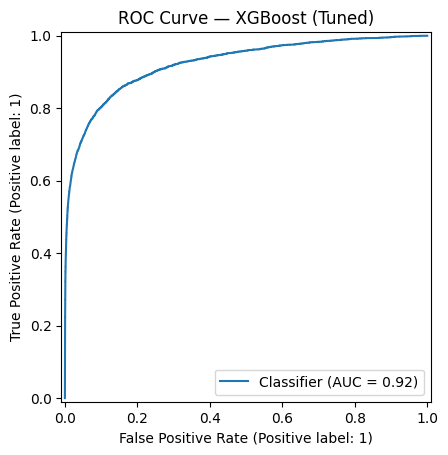

<Figure size 640x480 with 0 Axes>

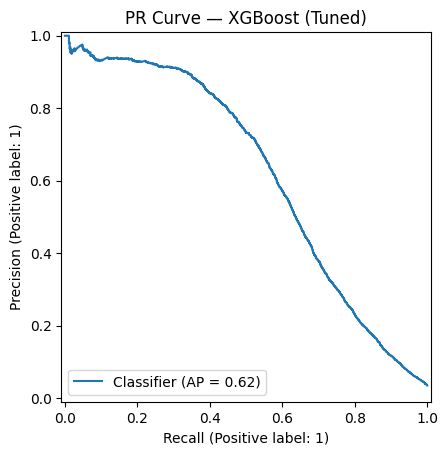

3431

In [18]:
best_params = best["params"] if best["params"] is not None else {"max_depth": 4, "min_child_weight": 10, "colsample_bytree": 0.6}

xgb_tuned = XGBClassifier(
    n_estimators=800,
    learning_rate=0.05,
    subsample=0.8,
    reg_lambda=2.0,
    max_bin=128,
    tree_method="hist",
    eval_metric="auc",
    objective="binary:logistic",
    random_state=42,
    scale_pos_weight=scale_pos_weight,
    n_jobs=2,
    **best_params
)

xgb_tuned.fit(Xtr_imp, ytr_use, eval_set=[(Xva_imp, yva_use)], verbose=50)

valid_proba_tuned = xgb_tuned.predict_proba(Xva_imp)[:, 1]
roc_tuned, pr_tuned = evaluate_model(yva_use, valid_proba_tuned, title="XGBoost (Tuned)")

gc.collect()


## Interpretation — XGBoost (Tuned)

Setelah tuning, performa meningkat:

Validation metrics:
- **ROC-AUC = 0.9245**
- **PR-AUC  = 0.6181**

Dibanding XGBoost awal:
- ROC-AUC naik dari ≈ 0.9210 → 0.9245
- PR-AUC naik dari ≈ 0.5989 → 0.6181 (lebih penting untuk data imbalanced)

Confusion matrix:
- TP = **3097**
- FN = **1036**
- FP = **7119**
- TN = **106856**

Interpretasi:
- Model menjadi lebih “tepat” (FP turun dibanding model XGB awal),
- trade-off: fraud yang lolos (FN) sedikit meningkat.
Ini wajar karena model makin ketat sehingga precision cenderung naik.


# Step: Threshold Analysis (Important for Fraud Detection)

Default threshold 0.5 tidak selalu optimal di data imbalanced.

Kita coba beberapa threshold dan lihat trade-off:
- Precision (berapa banyak prediksi fraud yang benar)
- Recall (berapa banyak fraud yang berhasil ditangkap)

Kamu bisa pilih threshold sesuai kebutuhan bisnis:
- Fraud detection biasanya butuh recall tinggi (menangkap fraud sebanyak mungkin)


In [19]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

thresholds = np.linspace(0.05, 0.95, 19)

rows = []
for t in thresholds:
    pred = (valid_proba_tuned >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(yva_use, pred).ravel()
    precision = tp / (tp + fp + 1e-12)
    recall    = tp / (tp + fn + 1e-12)
    rows.append([t, precision, recall, tp, fp, fn])

thr_df = pd.DataFrame(rows, columns=["threshold", "precision", "recall", "tp", "fp", "fn"])
thr_df.sort_values("recall", ascending=False).head(10)


,threshold,precision,recall,tp,fp,fn
0,0.05,0.052680,0.976530,4036,72577,97
1,0.10,0.071693,0.950399,3928,50861,205
2,0.15,0.092586,0.927897,3835,37586,298
3,0.20,0.115244,0.902492,3730,28636,403
4,0.25,0.140387,0.876119,3621,22172,512
5,0.30,0.168110,0.855069,3534,17488,599
6,0.35,0.198027,0.825792,3413,13822,720
7,0.40,0.229563,0.800387,3308,11102,825
8,0.45,0.265474,0.775224,3204,8865,929
9,0.50,0.303152,0.749335,3097,7119,1036


## Interpretation — Threshold Analysis

Tabel threshold menunjukkan trade-off precision vs recall:

Contoh dari output:
- Threshold **0.05**
  - Precision ≈ **0.0527** (banyak false positive)
  - Recall ≈ **0.9765** (hampir semua fraud tertangkap)
- Threshold **0.50**
  - Precision ≈ **0.3032** (lebih sedikit false positive)
  - Recall ≈ **0.7493** (lebih banyak fraud lolos dibanding threshold rendah)

Kesimpulan:
- Threshold kecil → **recall tinggi**, tapi false positive tinggi
- Threshold besar → **precision naik**, tapi recall turun

Pemilihan threshold tergantung tujuan:
- jika ingin menangkap fraud sebanyak mungkin → pilih threshold lebih kecil
- jika ingin mengurangi false alarm → pilih threshold lebih besar


# Step: Feature Importance (XGBoost)

Untuk interpretasi, kita lihat feature importance dari XGBoost.

Catatan:
Karena kita menggunakan Frequency Encoding, nama kolom masih sama dan mudah diinterpretasikan.


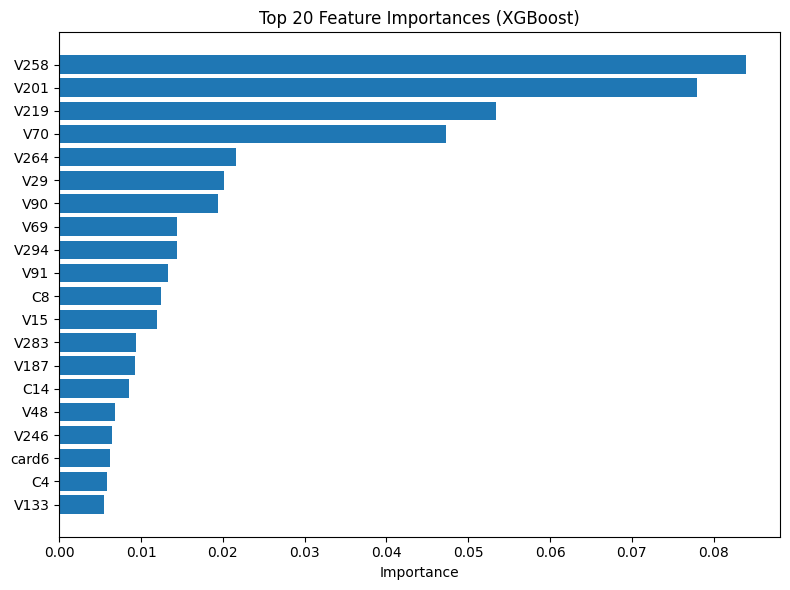

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# xgb_tuned.feature_importances_ sesuai urutan kolom setelah FE
feature_names = list(X_train_fe.columns)
importances = xgb_tuned.feature_importances_

idx = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(8, 6))
plt.barh([feature_names[i] for i in idx][::-1], importances[idx][::-1])
plt.title("Top 20 Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


# Final Step: Generate Submission (RAM-Friendly)

Test set berukuran besar, jadi prediksi dilakukan **per chunk** untuk menghindari crash (out-of-RAM).

Output file:
- `submission.csv` berisi:
  - `TransactionID`
  - `isFraud` (probabilitas fraud dari model)


In [21]:
import pandas as pd

# Pastikan test ada (buat ambil TransactionID)
if "test" not in globals():
    print("Variable `test` not found. Reloading test from test_path...")
    test = pd.read_csv(test_path, engine="pyarrow", dtype_backend="pyarrow")

assert "TransactionID" in test.columns, "Kolom TransactionID tidak ditemukan di test!"
test_ids = test["TransactionID"].to_numpy()

print("test_ids length:", len(test_ids))


Variable `test` not found. Reloading test from test_path...
test_ids length: 506691


In [22]:
import numpy as np
import gc

assert "test_fe" in globals(), "test_fe tidak ditemukan."
assert "X_train_fe" in globals(), "X_train_fe tidak ditemukan."
assert "xgb_tuned" in globals(), "xgb_tuned tidak ditemukan."

feature_cols = list(X_train_fe.columns)

# median untuk fillna
if "med_used" in globals():
    med = med_used
else:
    print("med_used not found -> using median from X_train_fe (fallback)")
    med = X_train_fe.median(numeric_only=True)

# pastikan median punya semua kolom numeric yang ada
# (kalau ada kolom yang tidak ada di med, akan tetap NaN -> nanti kita isi 0 di chunk)
print("Num medians:", len(med))
gc.collect()


Num medians: 392


5466

In [23]:
import numpy as np
import pandas as pd
import gc

# test_ids buat submission
if "test" not in globals():
    print("Reloading `test` to get TransactionID...")
    test = pd.read_csv(test_path, engine="pyarrow", dtype_backend="pyarrow")
test_ids = test["TransactionID"].to_numpy()

def predict_test_chunks_xgb(model, test_fe_df, feature_cols, med_series, chunk_size=20000):
    preds = np.zeros(len(test_fe_df), dtype=np.float32)

    for start in range(0, len(test_fe_df), chunk_size):
        end = min(start + chunk_size, len(test_fe_df))
        chunk = test_fe_df.iloc[start:end]

        # align columns (jaga-jaga kalau urutan beda)
        chunk = chunk.reindex(columns=feature_cols)

        # fillna median untuk numeric columns yang ada di med_series
        # ini aman meskipun chunk punya kolom non-numeric (tapi seharusnya FE sudah numeric semua)
        chunk = chunk.fillna(med_series)

        # sisa NaN (kolom yang tidak punya median) -> isi 0
        chunk = chunk.fillna(0)

        # cast float32 dan predict
        X_chunk = chunk.to_numpy(np.float32, copy=False)
        preds[start:end] = model.predict_proba(X_chunk)[:, 1].astype(np.float32)

        # cleanup per iterasi biar RAM stabil
        del chunk, X_chunk
        gc.collect()
        print(f"Predicted {end:,}/{len(test_fe_df):,}")

    return preds

# turunkan chunk_size kalau masih berat: 10000 atau 5000
test_proba = predict_test_chunks_xgb(
    model=xgb_tuned,
    test_fe_df=test_fe,
    feature_cols=feature_cols,
    med_series=med,
    chunk_size=20000
)

print("Done. Proba stats:", float(test_proba.min()), float(test_proba.mean()), float(test_proba.max()))


Predicted 20,000/506,691
Predicted 40,000/506,691
Predicted 60,000/506,691
Predicted 80,000/506,691
Predicted 100,000/506,691
Predicted 120,000/506,691
Predicted 140,000/506,691
Predicted 160,000/506,691
Predicted 180,000/506,691
Predicted 200,000/506,691
Predicted 220,000/506,691
Predicted 240,000/506,691
Predicted 260,000/506,691
Predicted 280,000/506,691
Predicted 300,000/506,691
Predicted 320,000/506,691
Predicted 340,000/506,691
Predicted 360,000/506,691
Predicted 380,000/506,691
Predicted 400,000/506,691
Predicted 420,000/506,691
Predicted 440,000/506,691
Predicted 460,000/506,691
Predicted 480,000/506,691
Predicted 500,000/506,691
Predicted 506,691/506,691
Done. Proba stats: 1.1614074537646957e-05 0.1549115926027298 0.9999394416809082


In [24]:
submission = pd.DataFrame({
    "TransactionID": test_ids,
    "isFraud": test_proba
})
submission.to_csv("submission.csv", index=False)
print("Saved: submission.csv")
submission.head()


Saved: submission.csv


,TransactionID,isFraud
0,3663549,0.057860
1,3663550,0.181051
2,3663551,0.033554
3,3663552,0.009285
4,3663553,0.014491
